In [1]:
import pandas as pd
df = pd.read_pickle('ecommerce_data_cleaned.pkl')
print("cleaned data")
df.info()

cleaned data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            5000 non-null   int64         
 1   customer_age        5000 non-null   int64         
 2   customer_gender     5000 non-null   category      
 3   product_category    5000 non-null   object        
 4   payment_method      5000 non-null   category      
 5   order_value_usd     5000 non-null   float64       
 6   delivery_time_days  5000 non-null   int64         
 7   customer_rating     5000 non-null   float64       
 8   returned            5000 non-null   object        
 9   order_date          5000 non-null   datetime64[ns]
 10  returned_status     5000 non-null   int64         
dtypes: category(2), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 361.5+ KB


In [3]:
import datetime as dt
from typing import Final

# Reference Date
Snapshot_date: Final = df['order_date'].max() + dt.timedelta(days=1)

# RFM Metrics

rfm: pd.DataFrame = df.assign(
    Recency = (Snapshot_date - df['order_date']).dt.days,
    Frequency = 1,
    Monetary = df['order_value_usd']
)[['Recency','Frequency','Monetary', 'customer_age', 'customer_rating']]

# Financial Integrity Check
print(f"RFM Metrix Generated. Total Entries: {len(rfm)}")
print(f"Average Recency: {rfm['Recency'].mean():.1f} days")
display(rfm.head())

RFM Metrix Generated. Total Entries: 5000
Average Recency: 2500.5 days


,Recency,Frequency,Monetary,customer_age,customer_rating
0,5000,1,1366.60,37,2.3
1,4999,1,1175.89,41,1.8
2,4998,1,1283.97,30,3.2
3,4997,1,1245.76,58,3.8
4,4996,1,1411.06,59,3.2


/var/folders/pb/6bhlmzkx375g_t63x2_w3gnc0000gn/T/ipykernel_42818/1085026963.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Cluster_Id', palette='viridis')


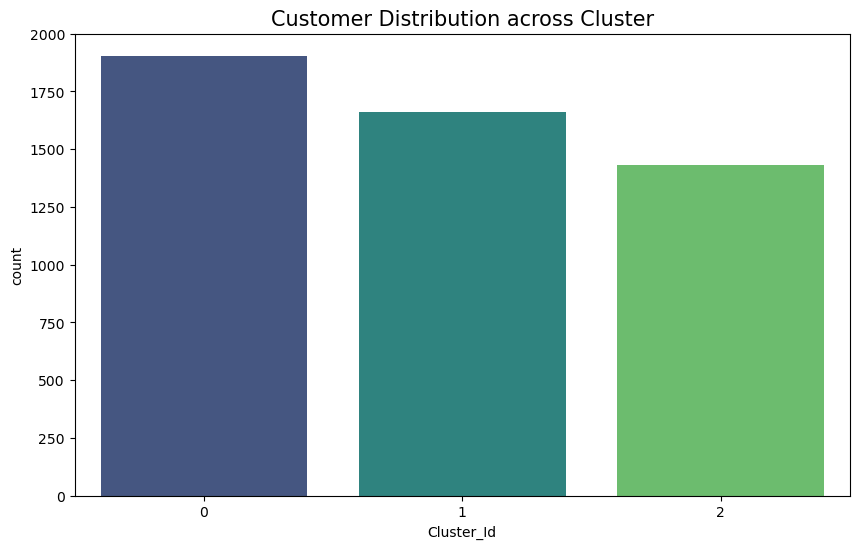

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-means clustering/Elbow method
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
rfm['Cluster_Id'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Cluster_Id', palette='viridis')
plt.title('Customer Distribution across Cluster', fontsize=15)
plt.show()



/var/folders/pb/6bhlmzkx375g_t63x2_w3gnc0000gn/T/ipykernel_42818/2057128068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='Cluster_Id', y=col, data=rfm, palette='viridis')
/var/folders/pb/6bhlmzkx375g_t63x2_w3gnc0000gn/T/ipykernel_42818/2057128068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='Cluster_Id', y=col, data=rfm, palette='viridis')
/var/folders/pb/6bhlmzkx375g_t63x2_w3gnc0000gn/T/ipykernel_42818/2057128068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='Cluster_Id', y=col, 

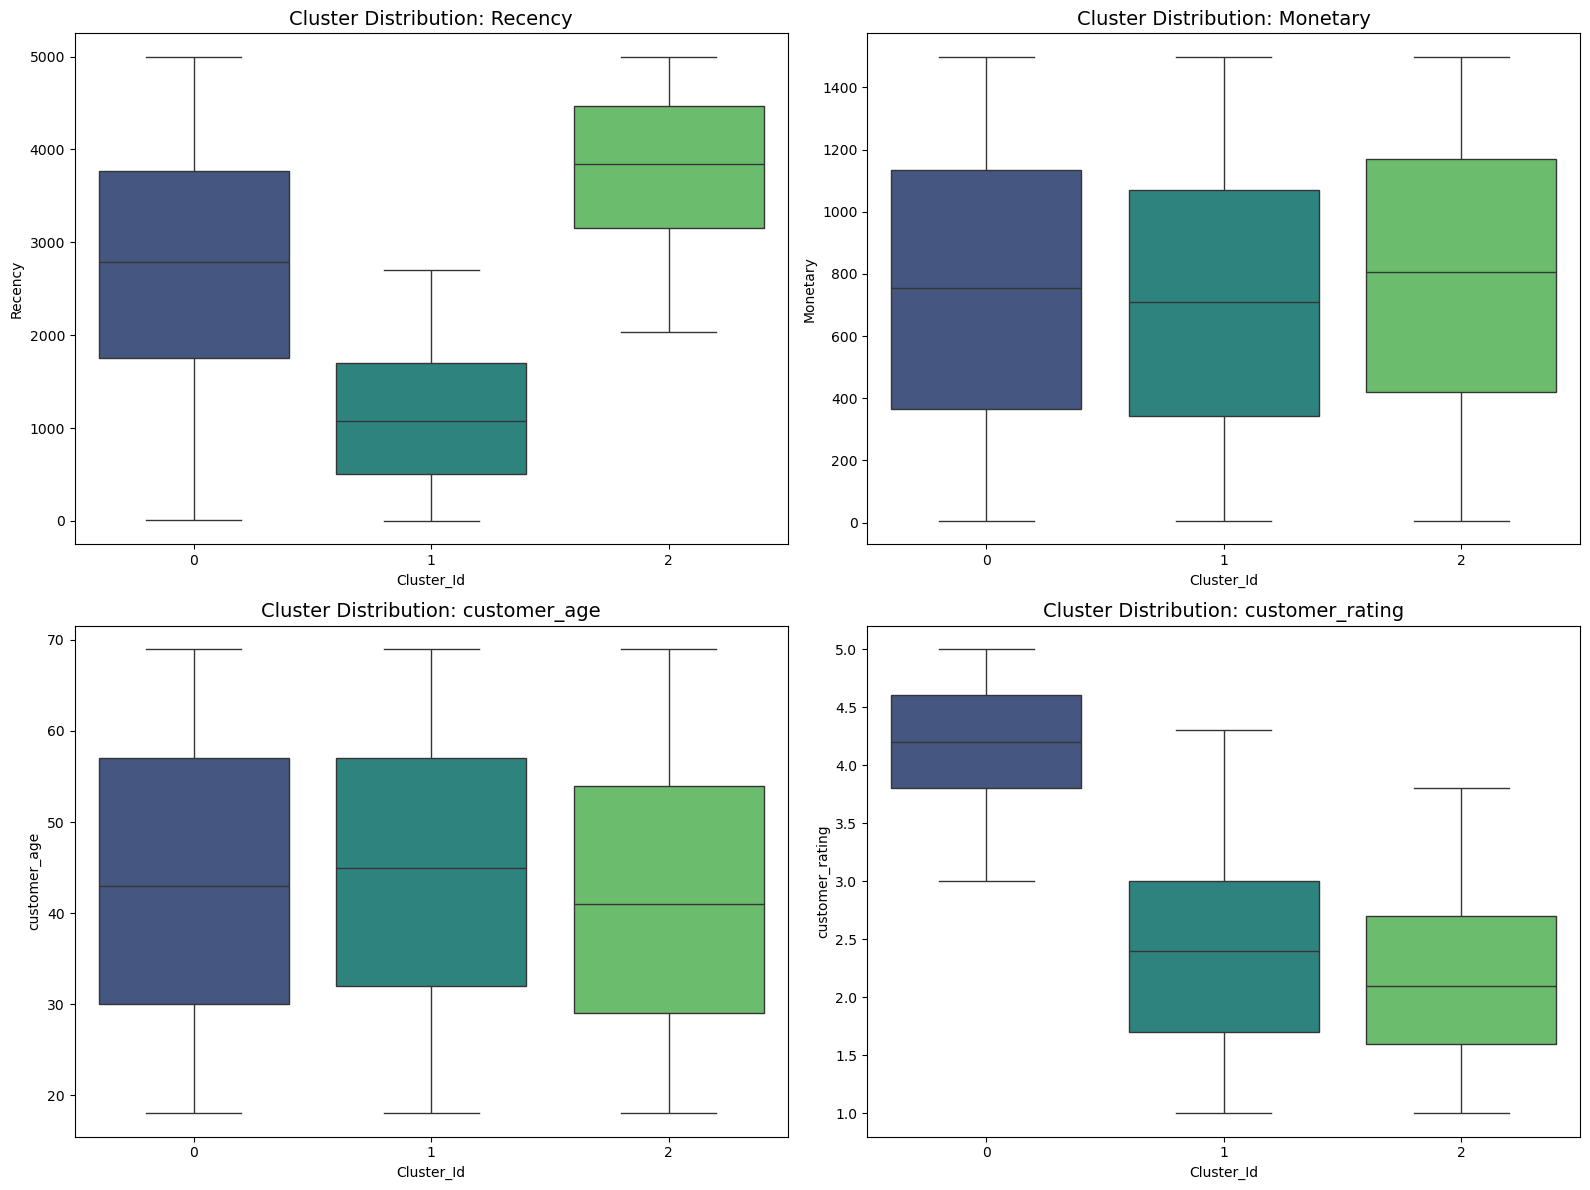

,Recency,Frequency,Monetary,customer_age,customer_rating
Cluster_Id,,,,,
0,2726.15,1.0,749.46,43.35,4.20
1,1126.50,1.0,716.43,44.31,2.39
2,3794.10,1.0,788.51,41.93,2.16


In [13]:
features_to_plot=['Recency', 'Monetary', 'customer_age','customer_rating']

fig,axes = plt.subplots(2,2, figsize=(16,12))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.boxplot(ax=axes[i], x='Cluster_Id', y=col, data=rfm, palette='viridis')
    axes[i].set_title(f'Cluster Distribution: {col}', fontsize=14)
    axes[i].set_ylabel(col)
    
plt.tight_layout()
plt.show()

cluster_profile = rfm.groupby('Cluster_Id').mean().round(2)
display(cluster_profile)

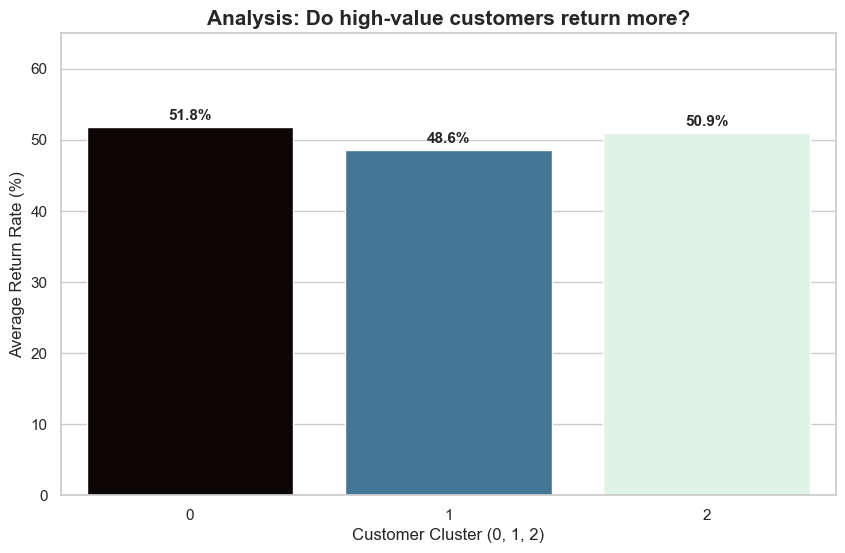

In [20]:

# Data Integration(Merging Returned Status)
rfm_with_returns: pd.DataFrame = rfm.copy()
rfm_with_returns['returned_status'] = df['returned_status']

# Calculate Return Rate by Cluster
cluster_behavior = rfm_with_returns.groupby('Cluster_Id').agg({
    'returned_status':'mean'
}).reset_index()

cluster_behavior['returned_rate_pct'] = cluster_behavior['returned_status'] * 100

# Visualization
plt.figure(figsize=(10,6))
sns.set_theme(style='whitegrid')

ax= sns.barplot(data=cluster_behavior, x='Cluster_Id', y='returned_rate_pct', palette='mako', hue='Cluster_Id', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=11, fontweight='bold')
    
plt.title('Analysis: Do high-value customers return more?', fontsize=15, fontweight='bold')
plt.ylabel('Average Return Rate (%)')
plt.xlabel('Customer Cluster (0, 1, 2)')
plt.ylim(0, 65)
plt.show()
